# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [2]:
import os
import pandas as pd  # use pandas to load data from CSV files
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn import hmm  # We recommend using this class if builing an HMM
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:


data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [4]:

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [5]:

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [6]:

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=23)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [7]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

print(len(X_given_y))


4


In [8]:

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)
    
print(diagonal_covars.shape)
print(means.shape)
print(len(X_by_seq_tr[0][0]))

(4, 6)
(4, 6)
6


## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [8]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [9]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

## Task 1

In [12]:
def make_nn(hidden_layer_size=100, 
            activation='relu',
            solver='adam',
            alpha=0.0001,
            learning_rate_init=0.001,
            learning_rate="constant",
            max_iter=200,
            n_iter_no_change=10,
            random_state=None,
            early_stopping=False,
            batch_size="auto"):
    
    nn_classifier = MLPClassifier(
                    hidden_layer_sizes=(hidden_layer_size),
                    activation=activation,
                    solver=solver,
                    alpha=alpha,
                    learning_rate_init=learning_rate_init,
                    learning_rate=learning_rate,
                    max_iter=max_iter,
                    n_iter_no_change=n_iter_no_change,
                    random_state=random_state,
                    early_stopping=early_stopping,
                    batch_size=batch_size)
    return nn_classifier

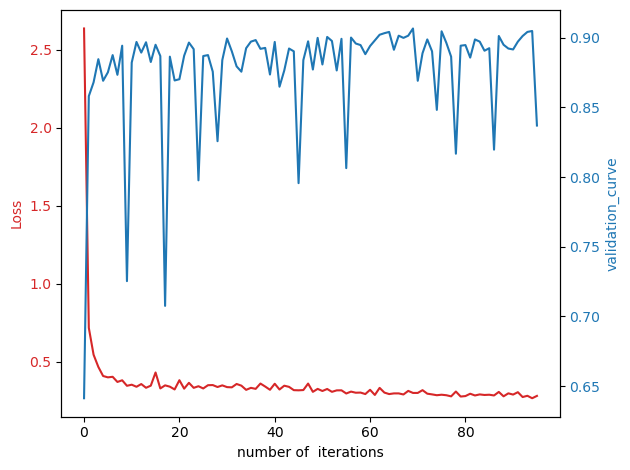

In [41]:
#a)

# look at learn rate, back at the a,b,c, see what tuning does - validation? 

#a) nn 
nn = MLPClassifier(early_stopping=True, n_iter_no_change=25)

nn.fit(X_tr, y_tr)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('number of  iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(nn.loss_curve_, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylim(0, 1)

color = 'tab:blue'
ax2.set_ylabel('validation_curve', color=color)  # we already handled the x-label with ax1
ax2.plot(nn.validation_scores_, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#include confusion matrix

Training accuracy:  0.9029
Testing accuracy:  0.8987
report_test:
               precision    recall  f1-score   support

           0       0.78      0.92      0.85      2354
           1       0.51      0.22      0.31       628
           2       0.99      1.00      0.99      4681
           3       0.94      0.55      0.69       307

    accuracy                           0.90      7970
   macro avg       0.81      0.67      0.71      7970
weighted avg       0.89      0.90      0.89      7970

report_train:
               precision    recall  f1-score   support

           0       0.78      0.92      0.85     12808
           1       0.63      0.35      0.45      3753
           2       0.99      1.00      1.00     26302
           3       0.92      0.47      0.62      1649

    accuracy                           0.90     44512
   macro avg       0.83      0.68      0.73     44512
weighted avg       0.90      0.90      0.89     44512



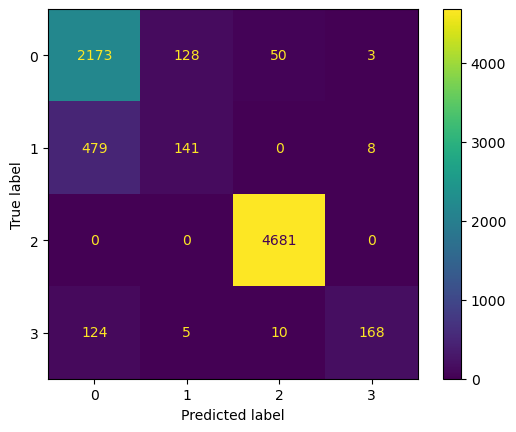

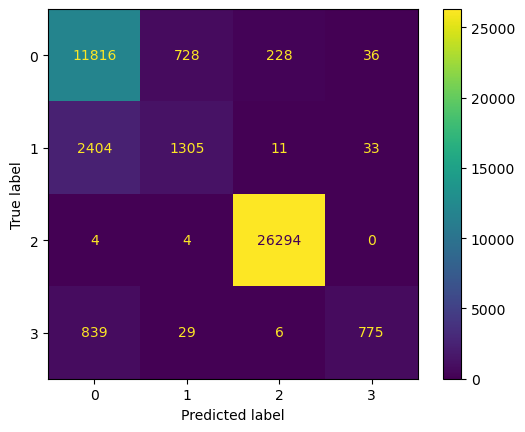

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, classification_report

print('Training accuracy: ', round(nn.score(X_tr, y_tr.flatten()),4))
print('Testing accuracy: ', round(nn.score(X_test, y_test.flatten()),4))

pred = nn.predict(X_test)
pred_tr = nn.predict(X_tr)
ConfusionMatrixDisplay.from_predictions(y_test, pred)
ConfusionMatrixDisplay.from_predictions(y_tr, pred_tr)



print("report_test:\n", classification_report(y_test, pred))
print("report_train:\n", classification_report(y_tr, pred_tr))
##accuracy, sensitivity, specificity, precision

In [29]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_tr, return_counts=True))

(array([0, 1, 2, 3], dtype=int64), array([2354,  628, 4681,  307], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([12808,  3753, 26302,  1649], dtype=int64))


hidden_layer_size###############
2
3
4
5
6
7
8
9
10
11
activation###############
logistic
tanh
relu
solver###############
sgd
adam
alpha###############
0
1
2
3
4
5
6
7
8
9
10
learning_rate_init###############
1e-06
1e-05
0.0001
0.001
0.01
0.1
1
n_iter_no_change###############
5
10
15
20
25
30
35
0
1
2
3
4
5


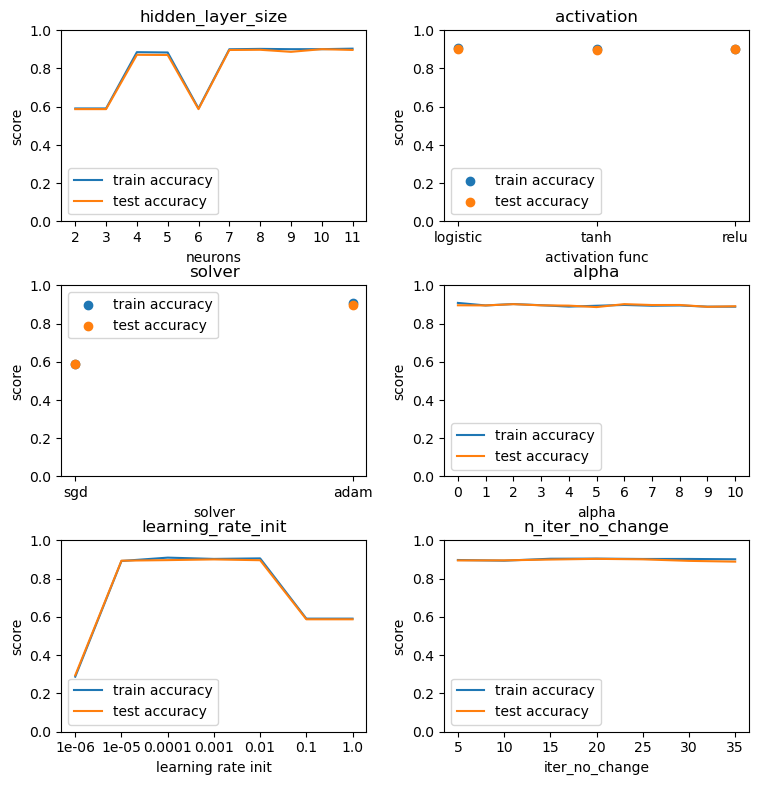

In [50]:
#c)
def plot_changes(legend, classifierArg, change_list, axs, subplotx, subploty, title="title"):
    print(classifierArg + "###############")

    axs[subplotx, subploty].set_title(title)

    nn_tr_scores = []
    nn_test_scores = []
    # iterate through lists of values to try for each argument
    for i in change_list:
        print(i)
        argument = {classifierArg : i}
        if legend != "iter_no_change":
            nn = make_nn(**argument, n_iter_no_change=25, max_iter=1000, early_stopping=True)
        else:
            nn = make_nn(**argument, max_iter=1000, early_stopping=True)

        nn.fit(X_tr, y_tr)
        nn_tr_scores.append(nn.score(X_tr, y_tr))
        nn_test_scores.append(nn.score(X_test, y_test))

    change_list = np.array(change_list).astype(str) # make x categorical
    axs[subplotx, subploty].set_ylim(0, 1)
    
    # plot graphs
    if legend not in ["activation func","solver"]:
        axs[subplotx, subploty].plot(change_list, nn_tr_scores)
        axs[subplotx, subploty].plot(change_list, nn_test_scores)
    else:
        axs[subplotx, subploty].scatter(change_list, nn_tr_scores)
        axs[subplotx, subploty].scatter(change_list, nn_test_scores)

    axs[subplotx, subploty].legend(["train accuracy", "test accuracy"])

figx = 3
figy = 2
fig, axs = plt.subplots(figx, figy, figsize=(8,8))
fig.tight_layout(pad=2.5)

#arguemnt names for MLP classifier
args=[
    "hidden_layer_size",
    "activation",
    "solver",
    "alpha",
    "learning_rate_init",
    "n_iter_no_change"
]
#values to try for each arguemnt
change_list=[
    [2,3,4,5,6,7,8,9,10,11], # neurons in hidden layer
    ["logistic", "tanh", "relu"], # activation functions identity is giving overflow
    ["sgd", "adam"], # solver
    [0,1,2,3,4,5,6,7,8,9,10], # alpha strength of L2 regularisation
    [10**-6, 10**-5, 10**-4, 10**-3, 0.01, 0.1, 1 ], # learning rate init
    [5, 10, 15, 20, 25, 30, 35] # tolerance for number of consequtive iterations with no change
]
#x axis label
legend_kwrd=[
    "neurons",
    "activation func",
    "solver",
    "alpha",
    "learning rate init",
    "iter_no_change"
]
# iterate through a selection of hyper parameters to try
for i in range(6):
    index = np.unravel_index(i, (figx,figy))
    plot_changes(
            legend = legend_kwrd[i],
            classifierArg = args[i],
            change_list=change_list[i],
            axs=axs,
            subplotx= index[0],
            subploty= index[1], 
            title="")
#label axis
for i, ax in enumerate(axs.flat):
    print(i)
    ax.set(xlabel=legend_kwrd[i], ylabel='score')


## Task 2

Train set accuracy (ensemble): 0.9515636232925953
Test set accuracy (ensemble): 0.9087829360100377


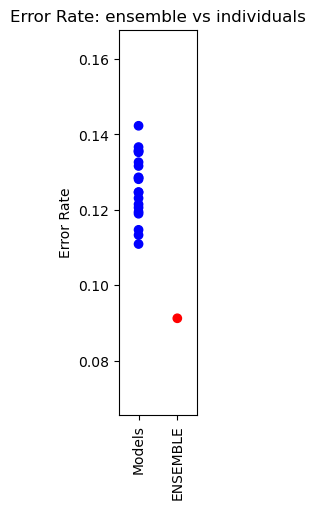

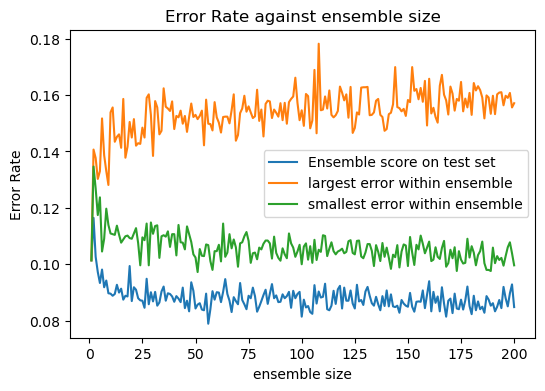

In [23]:
#a) Train an ensemble of decision trees, and briefly describe how your
#   ensemble improves performance over a single model. 

# wisdom of the crowd

from numpy import int64
np.random.seed(0)

def plot_ensemble_v_individuals(all_models, ensemble_acc, data, labels):
    # when plotting average error rate for number of base models average the error rate for combinations
    plotInfo = {
            "categories": np.append(["Models" for i in range(len(all_models))], ["ENSEMBLE"]),
            "Acc": np.append([1-model.score(data, labels) for model in all_models], [1-ensemble_acc])}
    
    df = pd.DataFrame.from_dict(plotInfo)

    fig, ax = plt.subplots(figsize=(1,5))
    ax.set_title("Error Rate: ensemble vs individuals")
    ax.scatter(df["categories"],
               df['Acc'],
               c=['red' if m=="ENSEMBLE" else 'blue' for m in df['categories']])
    ax.set(ylabel="Error Rate")
    plt.xticks(rotation=90)
    plt.margins(0.5)
    plt.show()

def plot_error_v_ensembleSize(ensemble_error_rates_test, max_model_err, min_model_err, ensemble_sizes):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title("Error Rate against ensemble size")
    ax.set(xlabel="ensemble size", ylabel="Error Rate")
    ax.plot(ensemble_sizes, ensemble_error_rates_test)
    ax.plot(ensemble_sizes, max_model_err)
    ax.plot(ensemble_sizes, min_model_err)
    ax.legend(["Ensemble score on test set", "largest error within ensemble", "smallest error within ensemble"])
    plt.show()

    return

def make_CART_ensemble(cart_arg={}, num_models=20, sample_size=2000):
    """Generates an ensemble"""
    all_models = []
    for m in range(num_models):
        sample_idx = np.random.choice(X_tr.shape[0], sample_size) # 2000 idx with replacement

        # select samples 
        X_train_sample, y_train_sample = X_tr[sample_idx], y_tr[sample_idx] 
        model = DecisionTreeClassifier(**cart_arg, max_features="sqrt")

        # train a decision tree classifier on the random sample.
        model.fit(X_train_sample,y_train_sample)
        
        all_models.append(model)
    return all_models

def make_CART_ensemble_pred(test_data, all_models):
    """(helper for ensemble_CART_ensemble) Uses an ensemble to make classifications on data"""
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 4?
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        votes[:, idx] = m.predict(test_data)

    for test_point in range(votes.shape[0]):
        combined_predictions[test_point] = np.bincount(int64(votes[test_point])).argmax()

    return combined_predictions # D x 1 vector for most likely class for each data point

def ensemble_CART_acc(test_data, labels, ensemble):
    """Finds the accuracy of an ensemble"""
    predictions = make_CART_ensemble_pred(test_data, ensemble)
    accuracy = np.count_nonzero(predictions == int64(labels))/labels.shape[0]
    return accuracy

############ error rate ensemble vs error rates of individuals #############
ensemble = make_CART_ensemble()
accuracy = ensemble_CART_acc(test_data=X_test, labels=y_test, ensemble=ensemble)
accuracy_tr = ensemble_CART_acc(test_data=X_tr, labels=y_tr, ensemble=ensemble)
print("Train set accuracy (ensemble): {}".format(accuracy_tr))
print("Test set accuracy (ensemble): {}".format(accuracy))
plot_ensemble_v_individuals(all_models=ensemble, ensemble_acc=accuracy, data=X_test, labels=y_test)

############ error rate ensemble vs ensemble size #############
ensemble_sizes = np.arange(1, 200+1) # 1 to 50
ensemble_set = [make_CART_ensemble(num_models=i) for i in ensemble_sizes]

ensemble_error_rates_test = [1-ensemble_CART_acc(test_data=X_test, labels=y_test, ensemble=ensemble) for ensemble in ensemble_set]
max_individual_errs = [] #[ max([model.score(X_test, y_test) for model in ensemble]) for ensemble in ensemble_set ] 
min_individual_err2 = [] #[ min([model.score(X_test, y_test) for model in ensemble]) for ensemble in ensemble_set ] 

for ensemble in ensemble_set:
    indidivdual_errors = []
    for model in ensemble:
        indidivdual_errors.append(1 - model.score(X_test, y_test))
    max_individual_errs.append(max(indidivdual_errors))
    min_individual_err2.append(min(indidivdual_errors))
        
plot_error_v_ensembleSize(ensemble_error_rates_test, max_individual_errs, min_individual_err2, ensemble_sizes)






criterion###############
3 3 ['gini', 'entropy', 'log_loss']
plotted
splitter###############
2 2 ['best', 'random']
plotted
max_depth###############
plotted
min_samples_split###############
plotted
min_samples_leaf###############
plotted
max_leaf_nodes###############
plotted
min_impurity_decrease###############
plotted
ccp_alpha###############
plotted


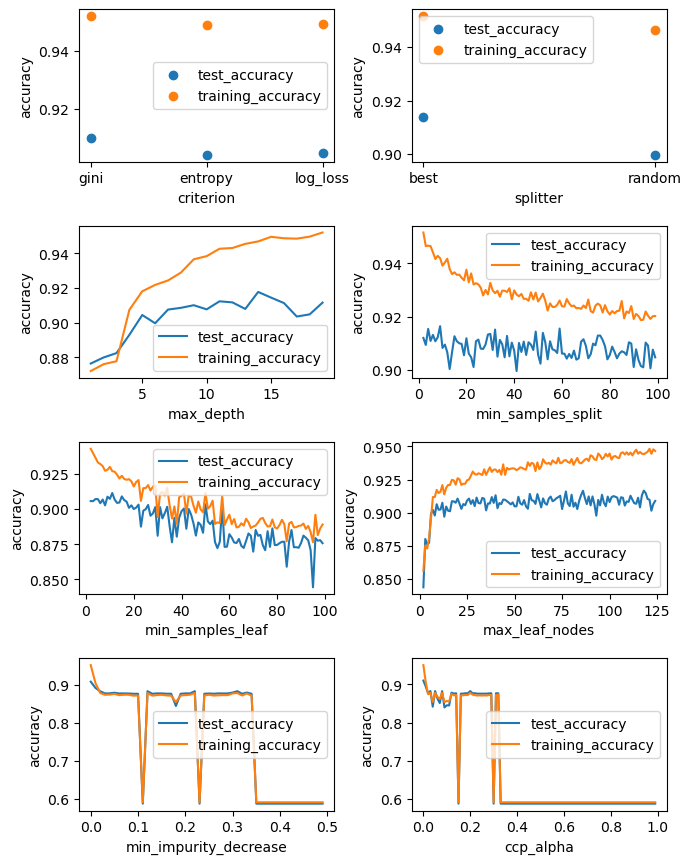

In [27]:
#d) How senstive is the model to different hyperparameters e.g. tree depth ?
##    use plots to explore differen trade-offs

def plot_CART_changes(legend_kwd, classifierArg, change_list, axs, subplotx, subploty, title="title"):
    """
    name: argument name for making cart ensemble\n
    change_list: interval/categories of change
    """
    print(classifierArg + "###############")

    axs[subplotx, subploty].set_title(title)
    
    test_acc = []
    train_acc = []
    x = change_list

    for i in change_list:
        kwarg = {classifierArg : i}
        cart_ensemble = make_CART_ensemble(num_models=20, cart_arg=kwarg)
        test_accuracy = ensemble_CART_acc(test_data=X_test, labels=y_test, ensemble=cart_ensemble)
        train_accuracy = ensemble_CART_acc(test_data=X_tr, labels=y_tr, ensemble=cart_ensemble)
        test_acc.append(test_accuracy)
        train_acc.append(train_accuracy)

    if classifierArg in ["criterion", "splitter"]:
        print(len(x), len(test_acc), change_list)
        axs[subplotx, subploty].scatter(x, test_acc)
        axs[subplotx, subploty].scatter(x, train_acc)
    else:
        axs[subplotx, subploty].plot(x, test_acc)
        axs[subplotx, subploty].plot(x, train_acc)

    axs[subplotx, subploty].legend(["test_accuracy", "training_accuracy"])

    axs[subplotx, subploty].set(xlabel=classifierArg, ylabel="accuracy")
    print("plotted")

args=[
    "criterion",
    "splitter",
    "max_depth",
    "min_samples_split",
    "min_samples_leaf",
    "max_leaf_nodes",
    "min_impurity_decrease",
    "ccp_alpha" # higher ccp_alpha priorities cost over fitting to data
]
change_list=[
    ["gini", "entropy", "log_loss"], #criterion
    ["best", "random"], # splitter
    [i for i in range(1, 20)], # max depth 
    [i for i in range(2, 100)], # min samples split
    [i for i in range(2, 100)], # min samples leaf
    [i for i in range(2, 125)],  #max leaf nodes,
    np.arange(0, 0.5, 0.01), # gini impurity
    np.arange(0, 1, 0.01) # ccp alpha
]

graphsX = 4
graphsY = 2

fig, axs = plt.subplots(graphsX, graphsY, figsize=(7,9))
fig.tight_layout(pad=2.5)

ensemble_sizes = 25
for i in range(len(change_list)):
    axIdx = np.unravel_index(i, (graphsX,graphsY))
    plot_CART_changes(
        legend_kwd=args[i],
        classifierArg=args[i],
        change_list=change_list[i],
        axs=axs,
        subplotx=axIdx[0],
        subploty=axIdx[1],
        title=""
    )

## Task 3

shape (7970, 6) (44512, 6)
transition_matrix:
 [[0.99203249 0.         0.00437432 0.00359319]
 [0.00026674 0.98986396 0.00080021 0.00906909]
 [0.00186354 0.00003803 0.99729976 0.00079866]
 [0.0265596  0.02347128 0.00617665 0.94379246]] 

initial_counts [15, 3, 10, 20]
diag_covars (4, 6)
No-EM train: 0.9084067217828901
No-EM test: 0.8806775407779172
with-EM train: 0.2501797268152408
with-EM test: 0.25734002509410286


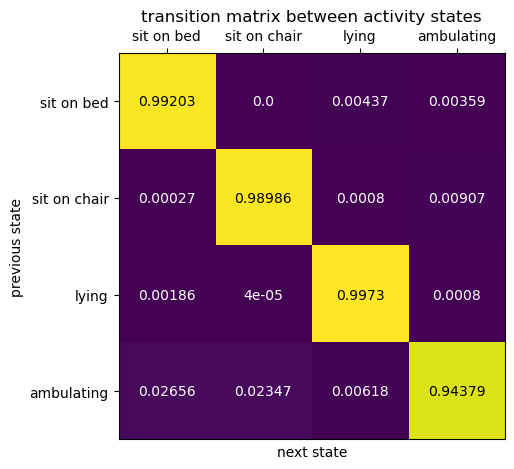

############# mean
[[  0.362   0.934   0.048 -58.964   3.163 922.72 ]
 [  0.553   0.865   0.065 -58.198   3.424 922.634]
 [  1.098  -0.012  -0.024 -58.483   3.318 922.81 ]
 [  0.218   0.966   0.02  -54.391   3.107 922.856]]
              frontal acc  vertical acc  lateral acc    RSSI  phase  frequency
sit on bed          0.362         0.934        0.048 -58.964  3.163    922.720
sit on chair        0.553         0.865        0.065 -58.198  3.424    922.634
lying               1.098        -0.012       -0.024 -58.483  3.318    922.810
ambulating          0.218         0.966        0.020 -54.391  3.107    922.856
diag covars
[[ 0.04631305  0.01007256  0.01205125  7.9363886   5.06377028  2.84884026]
 [ 0.06008558  0.01010979  0.01226912 15.81894708  4.98789238  3.2989204 ]
 [ 0.02693508  0.01585012  0.04254624 25.23853528  5.02800153  2.83453339]
 [ 0.04699356  0.01431682  0.02116073 57.13696284  4.66925184  2.89361544]]


<Axes: >

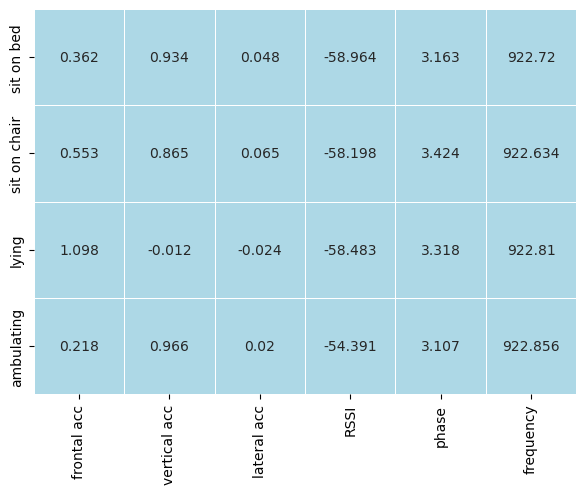

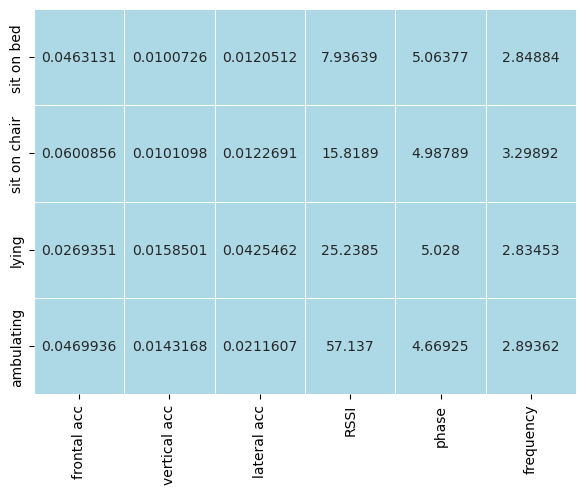

In [15]:
# List of 2D numpy arrays
#   X_by_seq_tr
#   X_by_seq_test

# List of 1D numpy arrays, each array contains the target class labels for each seq
# y_by_seq_tr
# y_by_seq_test

# sequence labeller 
from nltk.probability import ConditionalFreqDist,ConditionalProbDist,MLEProbDist

def state_init_prob(state_labels_lists) -> list:
    initial_counts = [0]*4
    for state_list in state_labels_lists: # for each label_list
        initial_counts[state_list[0]] += 1

    print("initial_counts",initial_counts)
    state_init_probabilities = np.array(initial_counts)/len(state_labels_lists)

    return state_init_probabilities

def transition_matrix(state_labels_lists, n_states=4) -> list:
    transition_counts = np.zeros((n_states, n_states))

    for state_labels in state_labels_lists:
        for i in range(len(state_labels) - 1): # iterate over everything except last label
            transition_counts[state_labels[i], state_labels[i+1]] += 1

    transition_matrix = transition_counts/transition_counts.sum(axis=1, keepdims=True)
    print("transition_matrix:\n",transition_matrix, "\n")

    return transition_matrix

nstep = 50
# data for training
concat_seq_X_tr = np.concatenate(X_by_seq_tr)
tr_lengths = [len(seq) for seq in X_by_seq_tr]
# data for testing lib
concat_seq_X_test = np.concatenate(X_by_seq_test)
test_lengths = [len(seq) for seq in X_by_seq_test]

print("shape", concat_seq_X_test.shape, concat_seq_X_tr.shape)

 # transition matrix and initial probabilities based on training data
transmat = transition_matrix(state_labels_lists=y_by_seq_tr)
init_probs = state_init_prob(state_labels_lists=y_by_seq_tr)
# gaussian hmm params based on test data
model1 = hmm.GaussianHMM(n_components=4, covariance_type="diag", init_params="", params="")
model1.startprob_ = init_probs
model1.transmat_ = transmat
model1.covars_ = diagonal_covars
print("diag_covars",diagonal_covars.shape)
model1.means_ = means
model1.fit(concat_seq_X_tr, lengths=tr_lengths)
# predict training and testing data
predicted_states = model1.predict(concat_seq_X_test, lengths=test_lengths)
predicted_states_tr = model1.predict(concat_seq_X_tr, lengths=tr_lengths)

# GaussianHMM with params from EM
model2 = hmm.GaussianHMM(n_components=4, covariance_type="diag").fit(concat_seq_X_tr, lengths=tr_lengths)
em_pred = model2.predict(concat_seq_X_test, lengths=test_lengths)
em_pred_tr = model2.predict(concat_seq_X_tr, lengths=tr_lengths)

accuracy1 = np.count_nonzero(predicted_states == np.concatenate(y_by_seq_test))/len(np.concatenate(y_by_seq_test))
accuracy1_tr = np.count_nonzero(predicted_states_tr == np.concatenate(y_by_seq_tr))/len(np.concatenate(y_by_seq_tr))

accuracy2 = np.count_nonzero(em_pred == np.concatenate(y_by_seq_test))/len(np.concatenate(y_by_seq_test))
accuracy2_tr = np.count_nonzero(em_pred_tr == np.concatenate(y_by_seq_tr))/len(np.concatenate(y_by_seq_tr))

print("No-EM train:",accuracy1_tr)
print("No-EM test:",accuracy1)

print("with-EM train:", accuracy2_tr)
print("with-EM test:", accuracy2)

################# plot transition matrix ####################
fig, ax = plt.subplots()
rounded_transmat = np.round(transmat, 5)
im = ax.imshow(rounded_transmat)

labels=["sit on bed", "sit on chair", "lying", "ambulating"]

#############################
ax.set_xticks(np.arange(len(transmat)), labels = labels)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(transmat)), labels = labels)

for i in range(len(transmat)):
    for j in range(len(transmat)):
        if i != j:
            text = ax.text(j, i, rounded_transmat[i, j], ha="center", va="center", color="white")
        else:
            text = ax.text(j, i, rounded_transmat[i, j], ha="center", va="center", color="black")

ax.set_title("transition matrix between activity states")
ax.set(xlabel="next state", ylabel="previous state")
fig.tight_layout()
plt.show()
np.set_printoptions(suppress=True)
#############################
print("############# mean")
means_rounded = np.round(means, 3)
print(means_rounded)
############################
# means heatmap plotting
from matplotlib.colors import ListedColormap
import seaborn as sns

df = pd.DataFrame(means_rounded, columns=["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"])
df.index = ["sit on bed", "sit on chair", "lying", "ambulating"]

df_n = (df-df.min())/(df-df.mean())/df.std()
print(df.to_string())

plt.figure(figsize=(7,5))
plt.xticks(rotation=90) 
plt.yticks(rotation=90) 
sns.heatmap(df, annot=df, cmap=ListedColormap(['lightblue']), linewidths=.5, fmt=".6g", cbar=False)

print("diag covars")
print(diagonal_covars)
df_cov = pd.DataFrame(diagonal_covars, columns=["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"])
df_cov.index = ["sit on bed", "sit on chair", "lying", "ambulating"]
plt.figure(figsize=(7,5))
plt.xticks(rotation=90) 
plt.yticks(rotation=90) 
sns.heatmap(df_cov, annot=df_cov, cmap=ListedColormap(['lightblue']), linewidths=.5, fmt=".6g", cbar=False)


## task 4

variances of pc1 and pc2:
 [442188.20291909   7169.67274   ]
variances of pc1 and pc2 ratio:
 [0.98229806 0.01592705]


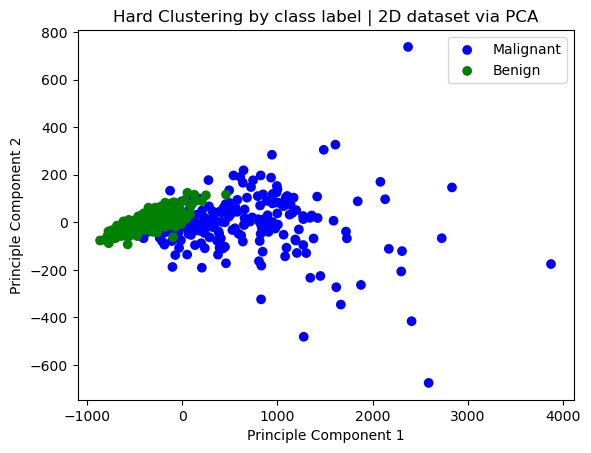

In [6]:
# READ IN THE DATA
from sklearn.decomposition import PCA

bc_data_path = "breast+cancer+wisconsin+diagnostic/wdbc.data"
bc_dataset = pd.read_csv(bc_data_path).to_numpy()  # full dataset
bc_dataset_30 = bc_dataset[:, 2:] # data set only keep the 30 features
class_labels =  bc_dataset[:, 1] # only the class labels

pca = PCA(n_components=2)
bc_reduced_2f = pca.fit_transform(bc_dataset_30)
print("variances of pc1 and pc2:\n", pca.explained_variance_)
print("variances of pc1 and pc2 ratio:\n", pca.explained_variance_ratio_)



fig, ax = plt.subplots()

benign_datapoints_reduced_2f = bc_reduced_2f[class_labels == "B"]
malignant_datapoints_reduced_2f = bc_reduced_2f[class_labels == "M"]
cmap = plt.get_cmap('cividis')



ax.scatter(malignant_datapoints_reduced_2f[:, 0], malignant_datapoints_reduced_2f[:, 1], c=["blue" for i in range(len(malignant_datapoints_reduced_2f))], label="Malignant")
ax.scatter(benign_datapoints_reduced_2f[:, 0], benign_datapoints_reduced_2f[:, 1], c=["green" for i in range(len(benign_datapoints_reduced_2f))], label="Benign")

ax.set_xlabel("Principle Component 1")
ax.set_ylabel("Principle Component 2")
ax.set_title("Hard Clustering by class label | 2D dataset via PCA")
plt.legend([ "Malignant","Benign"])
plt.show()

## Task 5

c:\Users\leoja\miniconda3\envs\COMS30035_labs\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


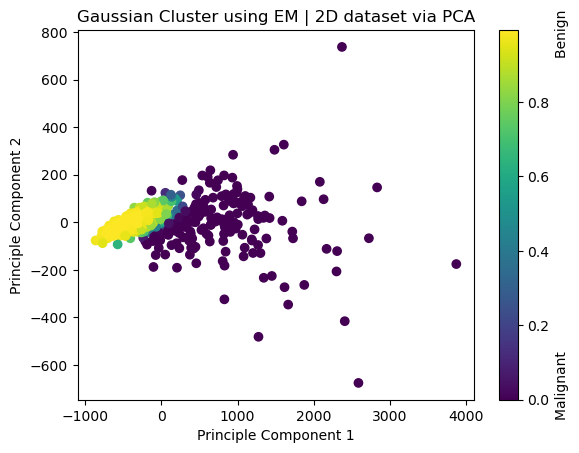

In [7]:
##################### soft clustering #######################
from sklearn.mixture import GaussianMixture

gmmModel = GaussianMixture(n_components=2).fit(bc_reduced_2f)

gmm_cluster_labels = gmmModel.predict(bc_reduced_2f)
gmm_resp = gmmModel.predict_proba(bc_reduced_2f)

fig, ax = plt.subplots()
scatter = ax.scatter(bc_reduced_2f[:, 0], bc_reduced_2f[:,1], c=gmm_resp[:,0])
ax.set_title("Gaussian Cluster using EM | 2D dataset via PCA")
plt.colorbar(scatter,label="Malignant                                                                   Benign")
ax.set_xlabel("Principle Component 1")
ax.set_ylabel("Principle Component 2")

plt.show()

## Task 7

In [8]:
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.metrics import accuracy_score

bc_X_tr = bc_dataset_30[:450]
bc_X_test = bc_dataset_30[450:]
print(bc_dataset_30.shape)

bc_y_tr = bc_dataset[:450, 1] # diagnosis column for the first 450
bc_y_test = bc_dataset[450:, 1] # diagnosis column for the last 118


kernels = ["linear", "poly", "rbf", "sigmoid"]
C_range = [1.0, 2.0, 3.0, 4, 5]
gamma_range = ["scale"] #["scale", "auto",1, 0.1, 0.01]

scores = []
attempts = []
for kernel in kernels:
    for c in C_range:
        for g in gamma_range:
            svm_model  = SVC(kernel=kernel, C=c, gamma=g)

            svm_model.fit(bc_X_tr, bc_y_tr)
            score = svm_model.score(bc_X_test, bc_y_test)
            
            attempt = [kernel, c, g, score]
            print(attempt)
            attempts.append(attempt)
            scores.append(score)
print("best")
best_idx = np.argmax(scores)
print("score:", scores[best_idx], "params:", attempts[best_idx])
#####################

(568, 30)
['linear', 1.0, 'scale', 0.940677966101695]
['linear', 2.0, 'scale', 0.9491525423728814]
['linear', 3.0, 'scale', 0.940677966101695]
['linear', 4, 'scale', 0.940677966101695]
['linear', 5, 'scale', 0.940677966101695]
['poly', 1.0, 'scale', 0.9491525423728814]
['poly', 2.0, 'scale', 0.9491525423728814]
['poly', 3.0, 'scale', 0.9576271186440678]
['poly', 4, 'scale', 0.9661016949152542]
['poly', 5, 'scale', 0.9576271186440678]
['rbf', 1.0, 'scale', 0.9491525423728814]
['rbf', 2.0, 'scale', 0.9576271186440678]
['rbf', 3.0, 'scale', 0.940677966101695]
['rbf', 4, 'scale', 0.9661016949152542]
['rbf', 5, 'scale', 0.9491525423728814]
['sigmoid', 1.0, 'scale', 0.4152542372881356]
['sigmoid', 2.0, 'scale', 0.3644067796610169]
['sigmoid', 3.0, 'scale', 0.3559322033898305]
['sigmoid', 4, 'scale', 0.3644067796610169]
['sigmoid', 5, 'scale', 0.3644067796610169]
best
score: 0.9661016949152542 params: ['poly', 4, 'scale', 0.9661016949152542]


## Task 8


In [36]:
#bc_reduced_2f
bc_X_tr = bc_reduced_2f[:450] # first 450 2featured samples
bc_y_tr = bc_dataset[:450, 1] # diagnosis column for the first 450

bc_X_test = bc_reduced_2f[450:] # last 118 2featured samples
bc_y_test = bc_dataset[450:, 1] # diagnosis column for the last 118

attempts2 = []

kernels = ["linear", "poly", "rbf", "sigmoid"]
C_range = [1.0, 2.0, 3.0, 4, 5]
gamma_range = ["scale"] #["scale", "auto",1, 0.1, 0.01]

scores = []
attempts = []

for kernel in kernels:
    for c in C_range:
        for g in gamma_range:
            svm_model  = SVC(kernel=kernel, C=c, gamma=g)

            svm_model.fit(bc_X_tr, bc_y_tr)
            score = svm_model.score(bc_X_test, bc_y_test)

            attempt = [kernel, c, g, score]
            print(attempt)
            
            attempts.append(attempt)
            scores.append(score)
print("best")
best_idx = np.argmax(scores)
print("score:", scores[best_idx], "params:", attempts[best_idx])


['linear', 1.0, 'scale', 0.9322033898305084]
['linear', 2.0, 'scale', 0.9322033898305084]
['linear', 3.0, 'scale', 0.9322033898305084]
['linear', 4, 'scale', 0.9322033898305084]
['linear', 5, 'scale', 0.9322033898305084]
['poly', 1.0, 'scale', 0.9152542372881356]
['poly', 2.0, 'scale', 0.923728813559322]
['poly', 3.0, 'scale', 0.923728813559322]
['poly', 4, 'scale', 0.923728813559322]
['poly', 5, 'scale', 0.923728813559322]
['rbf', 1.0, 'scale', 0.9491525423728814]
['rbf', 2.0, 'scale', 0.9491525423728814]
['rbf', 3.0, 'scale', 0.9491525423728814]
['rbf', 4, 'scale', 0.940677966101695]
['rbf', 5, 'scale', 0.9322033898305084]
['sigmoid', 1.0, 'scale', 0.8728813559322034]
['sigmoid', 2.0, 'scale', 0.8559322033898306]
['sigmoid', 3.0, 'scale', 0.8389830508474576]
['sigmoid', 4, 'scale', 0.8305084745762712]
['sigmoid', 5, 'scale', 0.8305084745762712]
best
score: 0.9491525423728814 params: ['rbf', 1.0, 'scale', 0.9491525423728814]


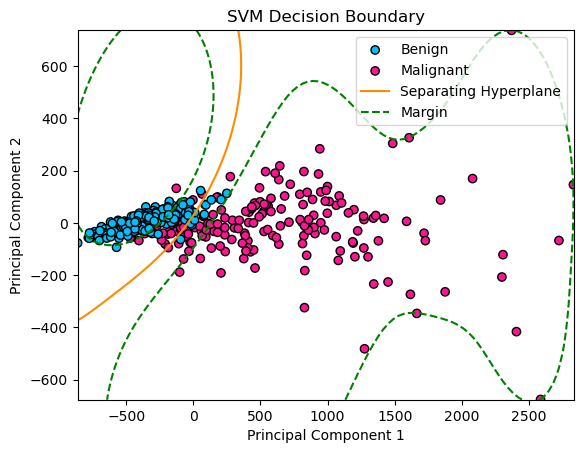

In [66]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.lines import Line2D
import matplotlib.markers as mmark

X_train, y_train = bc_X_tr, bc_y_tr
X_test, y_test = bc_X_test, bc_y_test

X, y = bc_X_tr, bc_y_tr

# fit the model, don't regularize for illustration purposes
clf = SVC(kernel="rbf", C=1)
clf.fit(X, y)

benign = X_train[y_train == "B"]
malignant = X_train[y_train == "M"]

sca1 = plt.scatter(malignant[:, 0], malignant[:, 1], c=["deeppink" for i in range(len(malignant))], marker='o', edgecolors='k', label="Malignant")
sca2 = plt.scatter(benign[:, 0], benign[:, 1], c=["deepskyblue" for i in range(len(benign))], marker='o', edgecolors='k', label="Benign")

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors=["green","darkorange"],
    levels=[-1, 0, 1],
    alpha=1,
    linestyles=["--", "-", "--"],
    ax=ax,
)

line = Line2D([0,1],[0,1],linestyle='-', color='darkorange')
line2 = Line2D([0,1],[0,1],linestyle='--', color='green')

plt.title('SVM Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.legend()
plt.legend([sca2, sca1, line, line2], ["Benign","Malignant","Separating Hyperplane", "Margin", ])
plt.show()

## Task 10

In [1]:
# predict number of bikes rented
# just produce posterior distributions and analyse them no need to predict
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

functioning day variance 0.032545454877201334
holiday variance 0.046888445074889706
dew point temp variance 170.5732472488832
temp variance 142.67884977591206
Date                               182.0
Rented Bike Count             704.602055
Hour                                11.5
Temperature(°C)                12.882922
Humidity(%)                    58.226256
Wind speed (m/s)                1.724909
Visibility (10m)             1436.825799
Dew point temperature(°C)       4.073813
Solar Radiation (MJ/m2)         0.569111
Rainfall(mm)                    0.148687
Snowfall (cm)                   0.075068
Seasons                         1.509589
Holiday                         0.950685
Functioning Day                 0.966324
Hour_sin                             0.0
Hour_cos                            -0.0
Seasons_sin                     -0.00274
Seasons_cos                    -0.005479
dtype: object


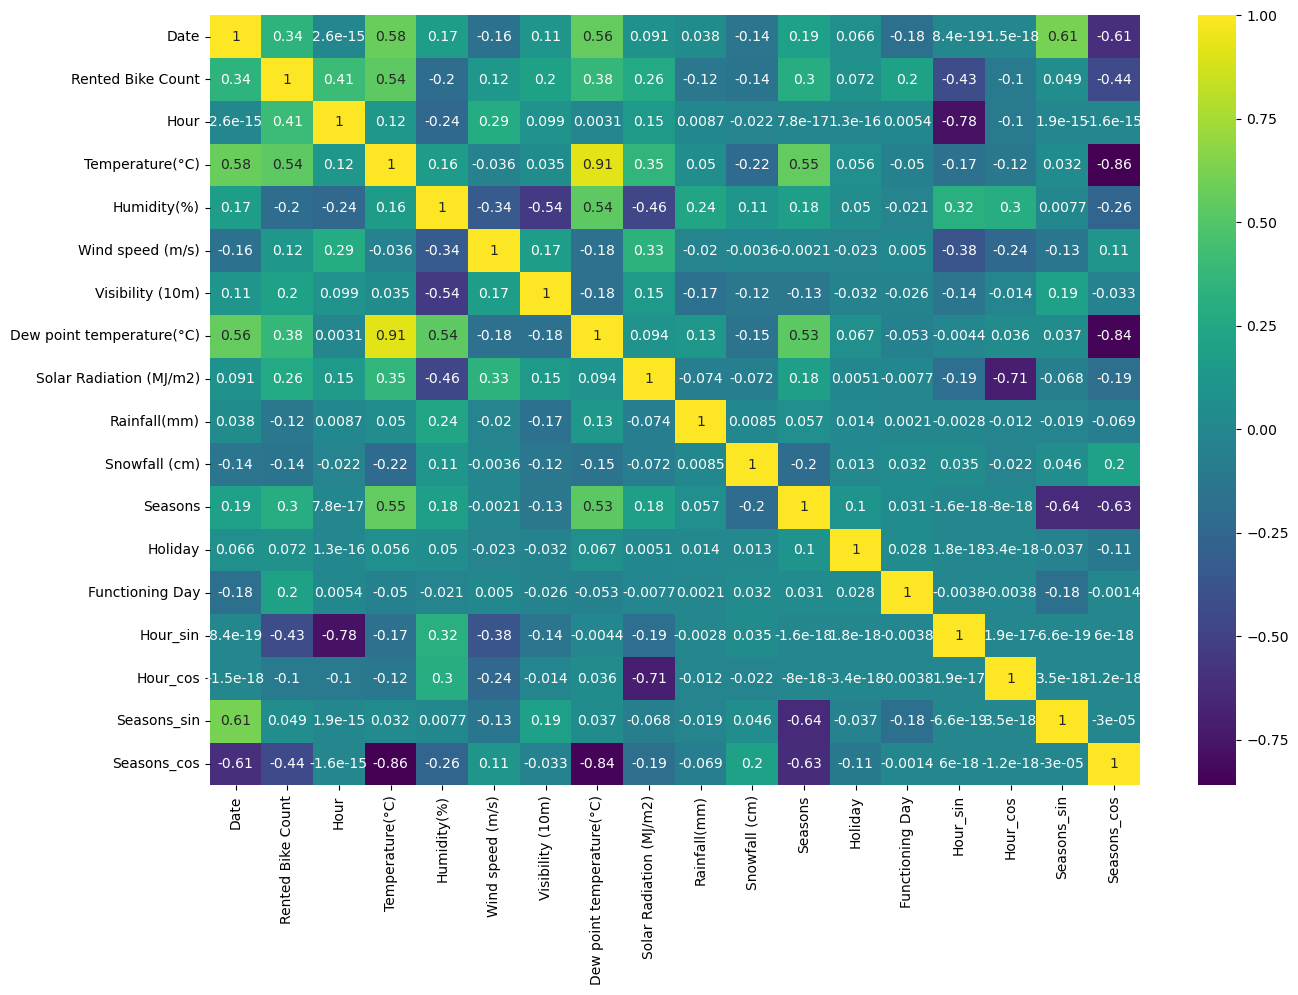

In [9]:
from sklearn.preprocessing import TargetEncoder, LabelEncoder
import seaborn as sns
import math

pd.set_option('expand_frame_repr', False)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

sb_data_path = "seoul+bike+sharing+demand/SeoulBikeData.csv"
seoul_dataset = pd.read_csv(sb_data_path)
#######################
# Convert date to number (ordinal encoding)

seoul_dataset['Date'] = pd.to_datetime(seoul_dataset['Date'], format="%d/%m/%Y")
initial_date = pd.to_datetime(seoul_dataset["Date"].min())
seoul_dataset["Date"] = (seoul_dataset["Date"] - initial_date).dt.days

#######################
target = seoul_dataset["Rented Bike Count"]
#############################
# label encoding
le = LabelEncoder()
for categorical in [ "Holiday", "Functioning Day"]:
    seoul_dataset.loc[:, categorical] = le.fit_transform(seoul_dataset[categorical])


# sine transformation to preserve cyclical nature of hours
seoul_dataset["Hour_sin"] = np.sin(seoul_dataset["Hour"]/12 * math.pi)
seoul_dataset["Hour_cos"] = np.cos(seoul_dataset["Hour"]/12 * math.pi)

# oridnal encoding
season_mapping = {'Winter': 0, 'Autumn': 1, 'Summer': 2, 'Spring': 3}
seoul_dataset["Seasons"] = seoul_dataset["Seasons"].map(season_mapping)
# cyclical encoding
seoul_dataset["Seasons_sin"] = np.sin(seoul_dataset["Seasons"]/2 * math.pi)
seoul_dataset["Seasons_cos"] = np.cos(seoul_dataset["Seasons"]/2 * math.pi)

print("functioning day variance",seoul_dataset["Functioning Day"].var())
print("holiday variance",seoul_dataset["Holiday"].var())
print("dew point temp variance",seoul_dataset["Dew point temperature(°C)"].var())
print("temp variance",seoul_dataset["Temperature(°C)"].var())


plt.subplots(figsize=(15,10))
sns.heatmap((seoul_dataset).corr(), annot=True, cmap="viridis")

# standardisation
print(seoul_dataset.mean())
seoul_dataset -= seoul_dataset.mean()
seoul_dataset /= seoul_dataset.std()
seoul_dataset = seoul_dataset.astype("float64")

######################################################
# not using hierarchal priors due to not having specific locaiton data in seoul

In [10]:
#'Rented Bike Count', 'Hour', 'Humidity(%)', 'Wind speed (m/s)','Visibility (10m)', 'Dew point temperature(°C)','Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons','Holiday'
# 11 features 
parameters = seoul_dataset.drop(columns=["Rented Bike Count", "Temperature(°C)", "Functioning Day", "Holiday", "Hour"])

print(parameters)
num_samples = 1000
model = pm.Model()

with model:
    ###########################
    # prior distributions: all have high variance and mean 0 (features have been standardised i.e. mean=0, sd=1)
    # i.e. not assumptions about the data
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    intercept = pm.Normal('intercept', mu=0, sigma=20)

    date = pm.Normal('Date', mu=0, sigma=20)
    hour_sin = pm.Normal('Hour_sin', mu=0, sigma=20)
    hour_cos = pm.Normal('Hour_cos', mu=0, sigma=20)
    humidity = pm.Normal('Humidity', mu=0, sigma=20)
    wind_spe = pm.Normal('Wind Speed', mu=0, sigma=20)
    visibility = pm.Normal('Visibility', mu=0, sigma=20)
    dew_point_temp = pm.Normal('Dew Point Temp', mu=0, sigma=20)
    solar_radiation = pm.Normal('Solar Radiation', mu=0, sigma=20)
    rainfall = pm.Normal('Rainfall', mu=0, sigma=20)
    snowfall = pm.Normal('Snowfall', mu=0, sigma=20)
    seasons_sin = pm.Normal('Seasons_sin', mu=0, sigma=20)
    seasons_cos = pm.Normal('Seasons_cos', mu=0, sigma=20)
    ###########################
    # estimation based on priors
    y_est = intercept\
            + date * parameters["Date"]\
            + hour_sin * parameters["Hour_sin"]\
            + hour_cos * parameters["Hour_cos"]\
            + humidity * parameters["Humidity(%)"]\
            + wind_spe * parameters["Wind speed (m/s)"]\
            + visibility * parameters["Visibility (10m)"]\
            + dew_point_temp * parameters["Dew point temperature(°C)"]\
            + solar_radiation * parameters["Solar Radiation (MJ/m2)"]\
            + rainfall * parameters["Rainfall(mm)"]\
            + snowfall * parameters["Snowfall (cm)"]\
            + seasons_sin * parameters["Seasons_sin"]\
            + seasons_cos * parameters["Seasons_cos"]\
    ###########################
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=target)
    sampler = pm.NUTS()

    trace = pm.sample(num_samples, step=sampler, progressbar=True, cores=8, chains=4)


          Date  Humidity(%)  Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)   Seasons      Hour_sin  Hour_cos  Seasons_sin  Seasons_cos
0    -1.727213    -1.042423          0.458450          0.925818                  -1.659510                -0.655094     -0.131792      -0.171881 -1.351672 -1.935620e-17  1.414133     0.003869     1.423876
1    -1.727213    -0.993313         -0.892511          0.925818                  -1.659510                -0.655094     -0.131792      -0.171881 -1.351672  3.660045e-01  1.365947     0.003869     1.423876
2    -1.727213    -0.944203         -0.699516          0.925818                  -1.667167                -0.655094     -0.131792      -0.171881 -1.351672  7.070664e-01  1.224675     0.003869     1.423876
3    -1.727213    -0.895093         -0.796013          0.925818                  -1.659510                -0.655094     -0.131792      -0.171881 -1.351672  9.999429e-01  0.999943  

Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sigma, intercept, Date, Hour_sin, Hour_cos, Humidity, Wind Speed, Visibility, Dew Point Temp, Solar Radiation, Rainfall, Snowfall, Seasons_sin, Seasons_cos]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


                   mean    sd  r_hat
intercept        704.52  0.21    1.0
Date              92.45  0.44    1.0
Hour_sin        -217.03  0.26    1.0
Hour_cos         -68.43  0.32    1.0
Humidity        -253.66  0.45    1.0
Wind Speed       -10.08  0.25    1.0
Visibility        11.65  0.28    1.0
Dew Point Temp   287.34  0.56    1.0
Solar Radiation  -95.05  0.38    1.0
Rainfall         -72.05  0.22    1.0
Snowfall          10.74  0.23    1.0
Seasons_sin      -45.94  0.35    1.0
Seasons_cos      -77.01  0.50    1.0
sigma             20.00  0.00    1.0


<Figure size 640x480 with 0 Axes>

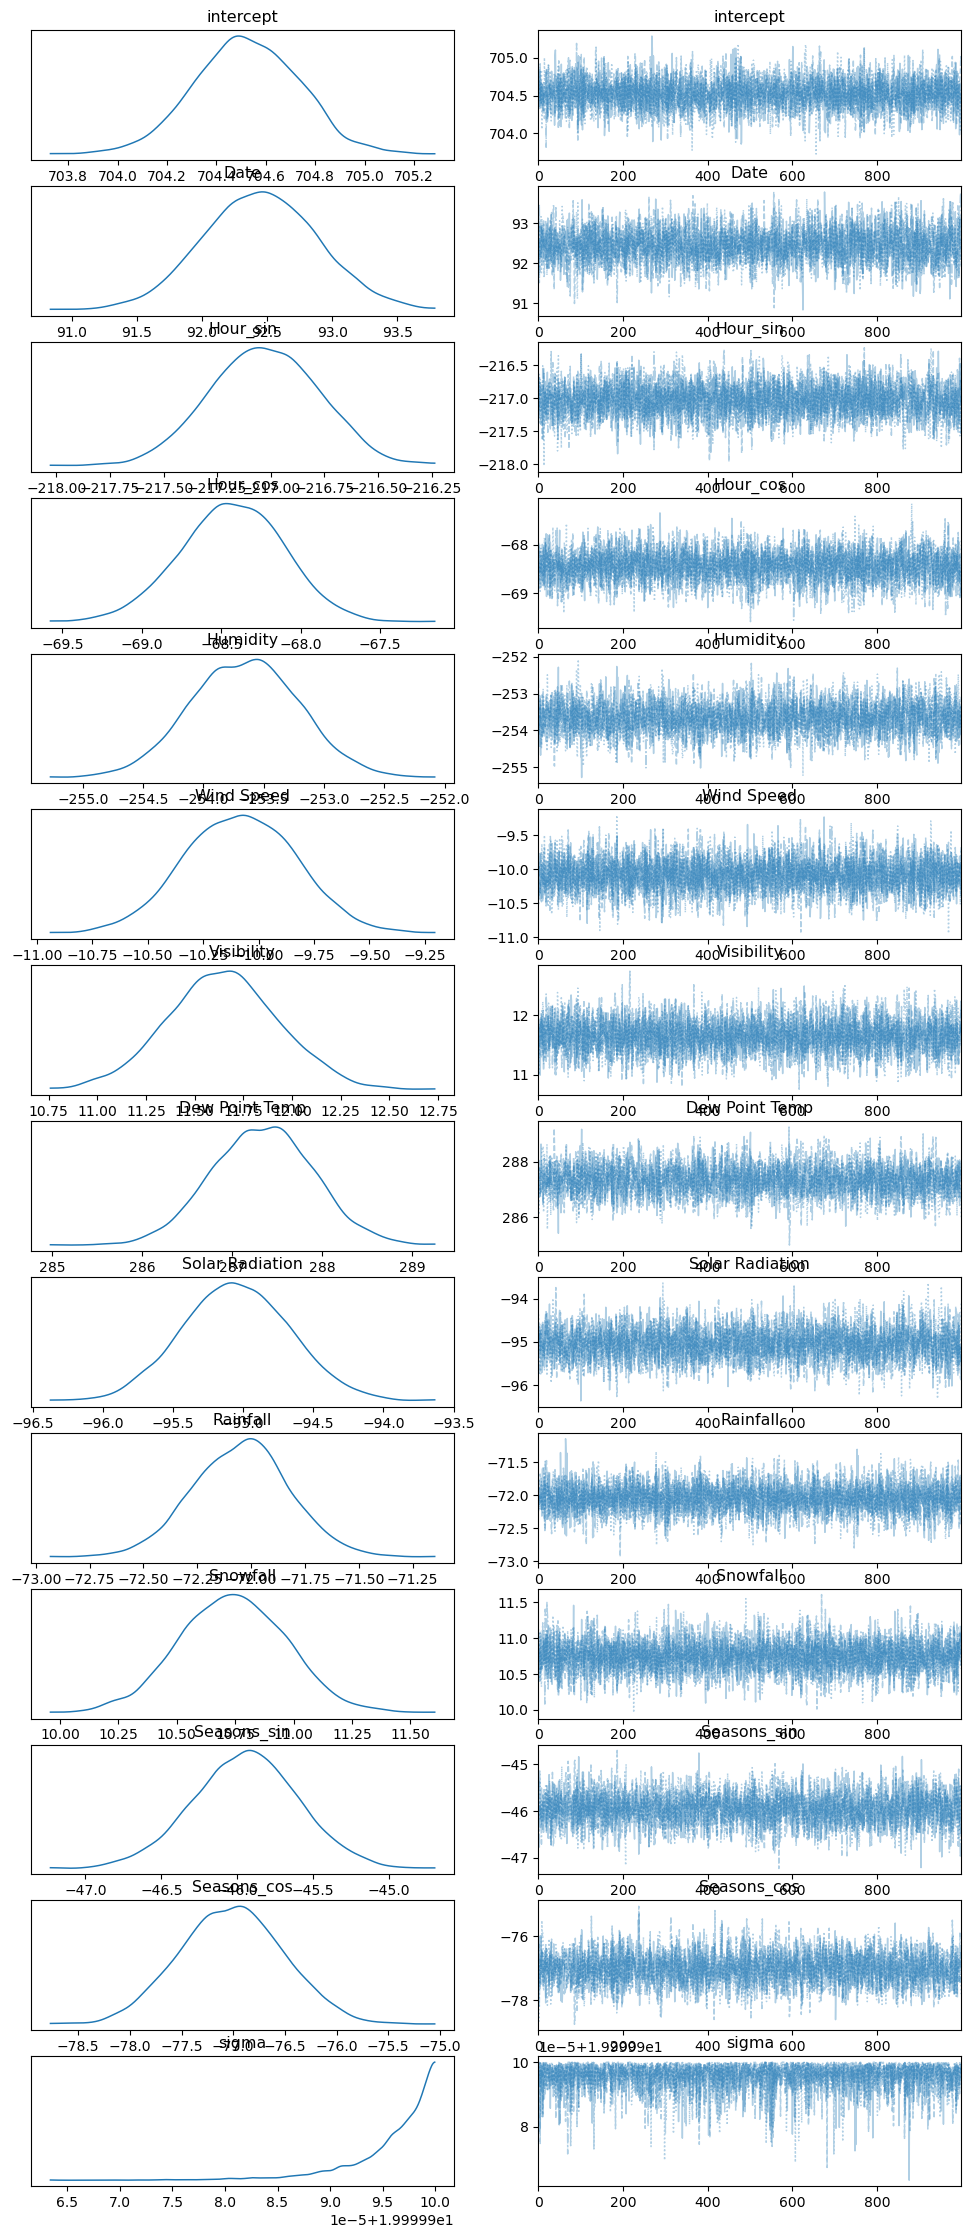

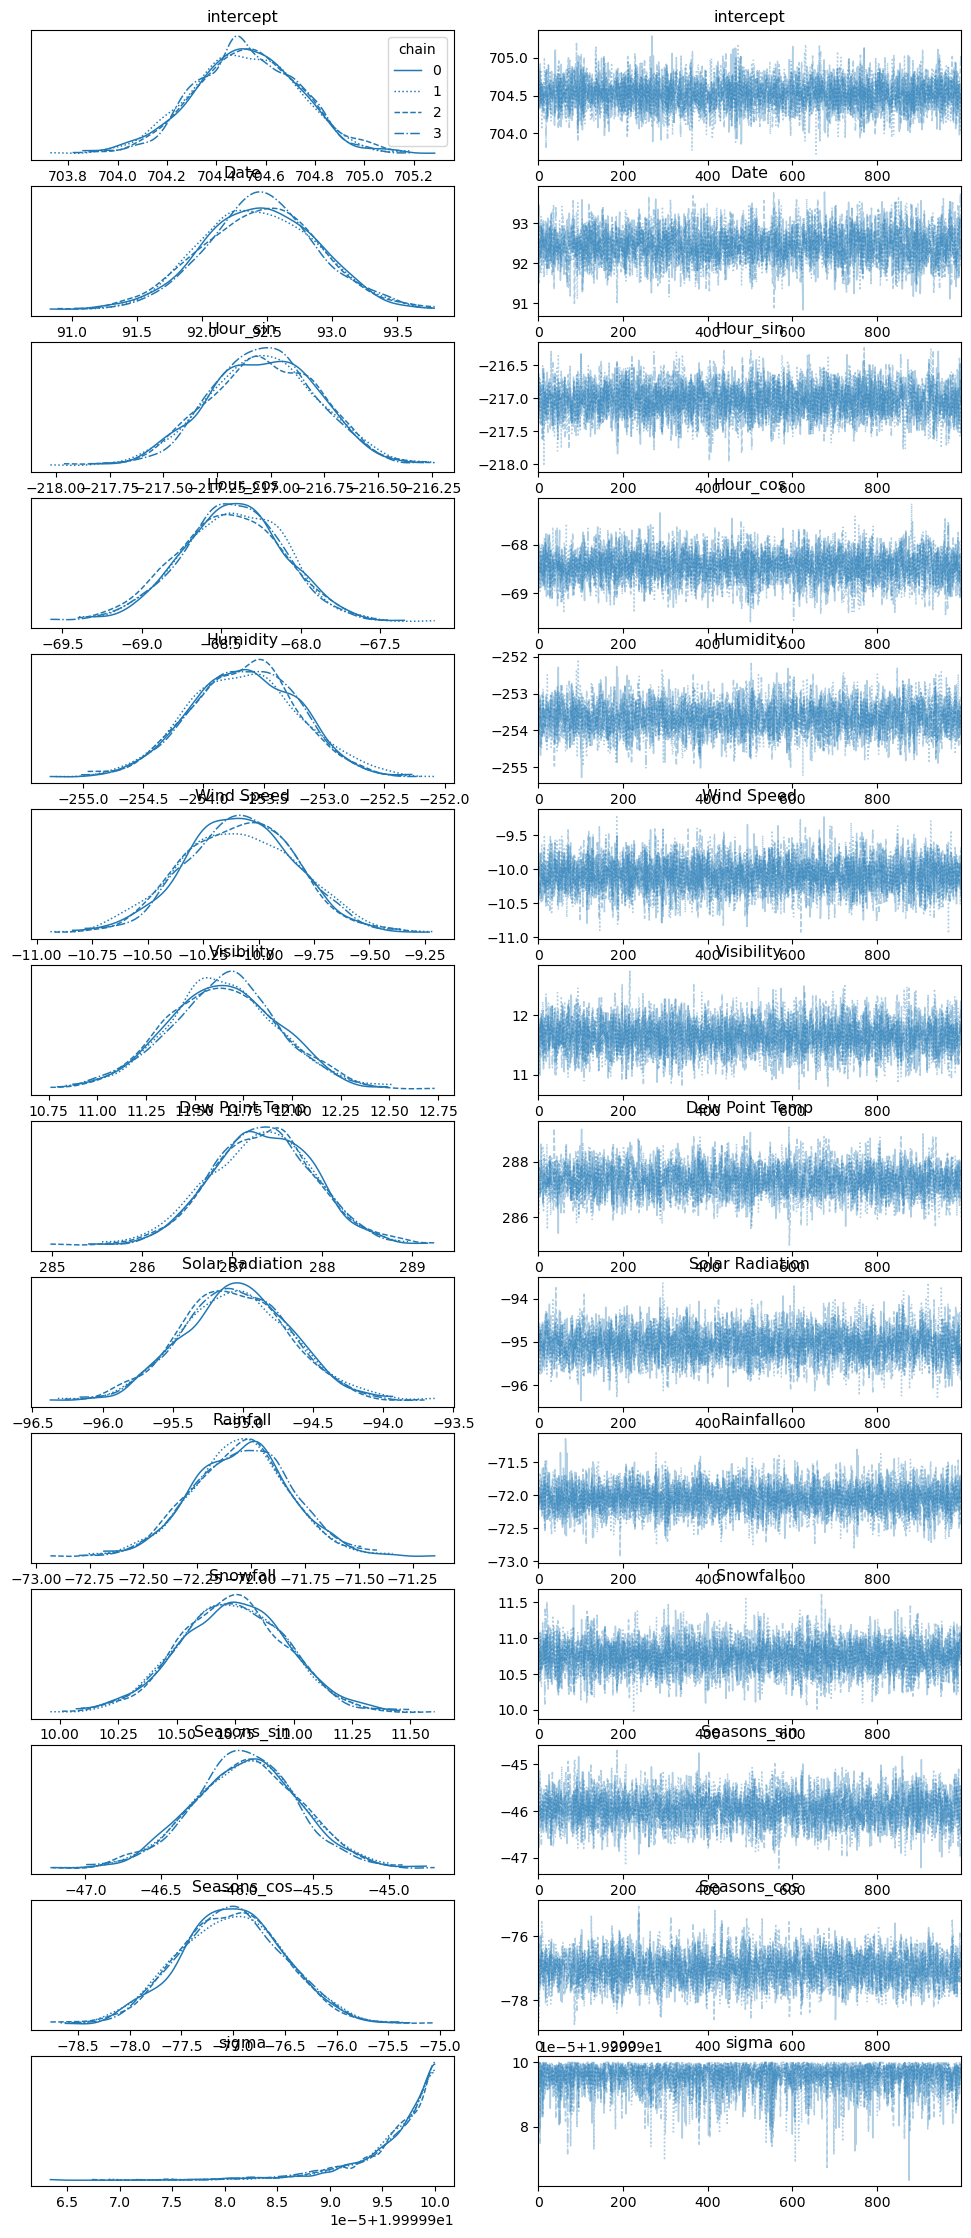

In [11]:
plt.tight_layout()
az.plot_trace(trace, combined=True)
az.plot_trace(trace,legend=True)
summary = az.summary(trace, round_to=2)
filtered_summaray = summary[["mean", "sd", "r_hat"]]
print(filtered_summaray)